In [139]:
import pandas  as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


In [140]:
df=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES+marrakech_lag_1.csv" )
#df=df[['date','TES']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()

In [141]:
df['TES'].describe()

count       184.000000
mean     447205.206522
std      190055.770198
min           0.000000
25%      382129.000000
50%      466409.000000
75%      542041.250000
max      966724.000000
Name: TES, dtype: float64

In [142]:
#df=df[:120]

## EDA

In [143]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Créer la plage de dates manquantes pour 2020 (12 mois)
# missing_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')

# # Créer un DataFrame avec les dates manquantes et valeur 0
# df_missing = pd.DataFrame({'Date': missing_2020, 'value': 0})

# # Fusionner avec ton DataFrame d'origine
# df_full = pd.concat([df, df_missing], ignore_index=True)
# df_full = df_full.sort_values('Date').reset_index(drop=True)
# df_full=df_full.drop('value',axis=1)
# df=df_full

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-01 to 2025-04-01
Freq: MS
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TES              184 non-null    float64
 1   marrakech_lag_1  183 non-null    float64
dtypes: float64(2)
memory usage: 4.3 KB


In [145]:
df.describe()

,TES,marrakech_lag_1
count,184.000000,183.000000
mean,447205.206522,59.808743
std,190055.770198,14.337055
min,0.000000,22.000000
25%,382129.000000,52.500000
50%,466409.000000,58.000000
75%,542041.250000,70.000000
max,966724.000000,100.000000


In [146]:
# Graphique interactif
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

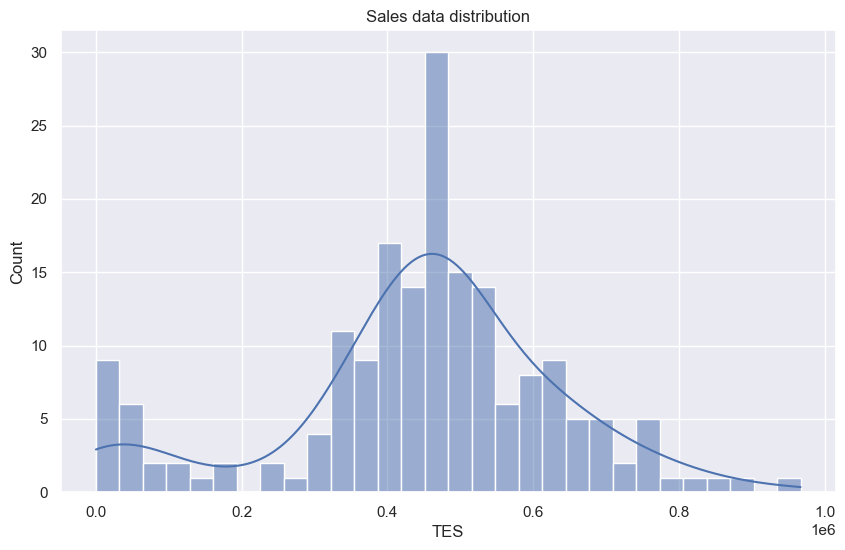

In [147]:
plt.figure(figsize=(10,6))
sns.histplot(df['TES'], kde=True, bins=30)
plt.title("Sales data distribution")
plt.show()

In [148]:
s = pd.to_numeric(df['TES'], errors="coerce").dropna()
nbins = 30

counts, edges = np.histogram(s, bins=nbins)
w = edges[1] - edges[0]
xbar = (edges[:-1] + edges[1:]) / 2

x = np.linspace(s.min(), s.max(), 400)
kde_counts = gaussian_kde(s)(x) * len(s) * w

fig = go.Figure([
    go.Bar(x=xbar, y=counts, width=w, marker_color="#9AC2F7", marker_line=dict(color="white", width=1), name="Count"),
    go.Scatter(x=x, y=kde_counts, mode="lines",marker_color="#144E9A", line=dict(width=2), name="KDE")
])
fig.update_layout(title="Distribution de TES", xaxis_title="TES", yaxis_title="Count", template="simple_white", width=900, height=520)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

##### Time series decomposition

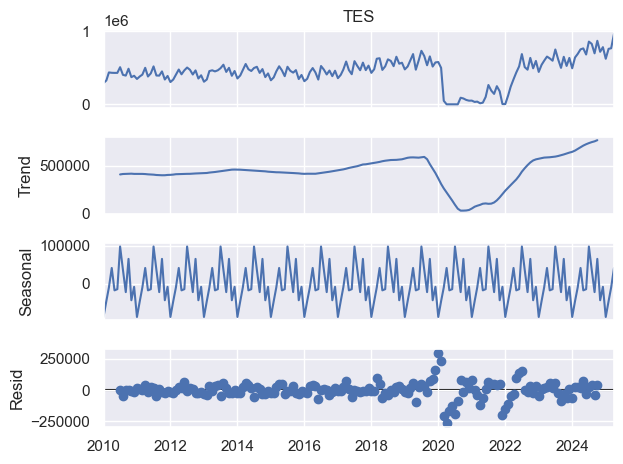

In [149]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df['TES'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


#### Augmented Dickey-Fuller test

In [150]:
def test_stationnarite(serie, nom='Serie'):
    result = adfuller(serie.dropna())
    print(f'--- ADF Test fot {nom} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] <= 0.05:
        print("✓ Série STATIONNAIRE (p-value ≤ 0.05)")
    else:
        print("✗ Série NON-STATIONNAIRE (p-value > 0.05)")    

In [151]:
test_stationnarite(df['TES'], 'TES')

--- ADF Test fot TES ---
ADF Statistic: -2.3420
p-value: 0.1588
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [152]:
df['TES_diff1'] = df['TES'].diff()
test_stationnarite(df['TES_diff1'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -2.7580
p-value: 0.0645
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [153]:
df['TES_diff2'] = df['TES'].diff().diff()
test_stationnarite(df['TES_diff2'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -10.7011
p-value: 0.0000
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [154]:
df

,TES,marrakech_lag_1,TES_diff1,TES_diff2
date,,,,
2010-01-01,291608.0,NaN,NaN,NaN
2010-02-01,327017.0,56.0,35409.0,NaN
2010-03-01,437338.0,61.0,110321.0,74912.0
2010-04-01,432338.0,62.0,-5000.0,-115321.0
2010-05-01,430974.0,60.0,-1364.0,3636.0
...,...,...,...,...
2024-12-01,784192.0,82.0,63725.0,214707.0
2025-01-01,624848.0,78.0,-159344.0,-223069.0
2025-02-01,761377.0,84.0,136529.0,295873.0


In [155]:
ts_d1 = df['TES'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 6.305047714926621e-05


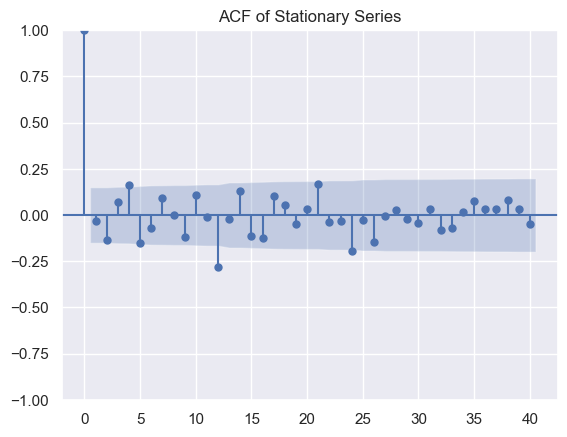

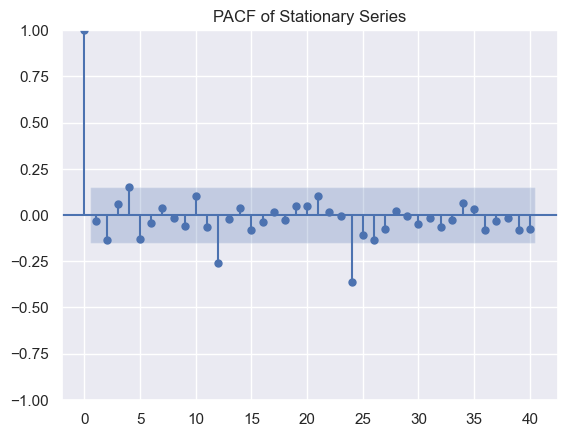

In [156]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

## Modeling

In [157]:
df.isnull().sum()

TES                0
marrakech_lag_1    1
TES_diff1          1
TES_diff2          2
dtype: int64

#### Premier décomposition 

In [194]:
train_a=df.loc['01-2010':'11-2023']
test_a=df.loc['12-2023':]
print("taille du train:",len(train_a),"\ntaille du test :",len(test_a))

taille du train: 167 
taille du test : 17


In [159]:
# train_a=df.loc['01-2010':'02-2020']
# test_a=df.loc['03-2020':]
# print("taille du train:",len(train_a),"\ntaille du test :",len(test_a))

#### deuxiéme decomposition

In [160]:
# train_b=df.loc['01-2010':'10-2022']
# test_b=df.loc['11-2022':]
# print("taille du train:",len(train_b),"\ntaille du test :",len(test_b))

#### troisiéme décomposition

In [161]:
# train_c=df.loc['01-2010':'01-2024']
# # test_c=df.loc['02-2024':]
# print("taille du train:",len(train_c),"\ntaille du test :",len(test_c))

In [162]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

#####  optimal orders

##### 1er décomposition 

In [163]:
meilleur = grid_search_sarima(train_a)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 72
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3925.71
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3896.24
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 3756.93
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3670.11
  Progression: 10/72 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3663.08
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3651.38
  Progression: 20/72 combinaisons testées (20 réussies)...
  Progression: 30/72 combinaisons testées (30 réussies)...
  Progression: 40/72 combinaisons testées (40 réussies)...
  Progression: 50/72 combinaisons testées (50 réussies)...
  Progression: 60/72 combinaisons testées (60 réussies)...
  Progression: 70/72 combinaisons testées (70 réussies)...
  Progression: 72/72 combinaisons testées (72 réussies)...

🏆 MEILLEUR MODÈLE

##### Fiting Models

In [195]:
model = SARIMAX(train_a["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])

In [165]:
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  TES   No. Observations:                  166
Model:             SARIMAX(0, 1, 0)x(2, 2, [1], 12)   Log Likelihood               -1821.690
Date:                              Thu, 23 Oct 2025   AIC                           3651.379
Time:                                      22:53:46   BIC                           3663.174
Sample:                                  01-01-2010   HQIC                          3656.172
                                       - 10-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3913      0.139     -2.807      0.005      -0.665      -0.118
ar.S.L24      -0.28

##### Predictions

In [196]:
predictions = results.predict(start=test_a.index[0], end=test_a.index[-1])

##### Metrics

In [197]:
rmse = root_mean_squared_error(test_a['TES'], predictions)
r2 = r2_score(test_a['TES'], predictions)
mae = mean_absolute_error(test_a['TES'], predictions)
mape = mean_absolute_percentage_error(test_a['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 81,131.97
MAE: 70,309.95
MAPE: 9.34%
R²: 43.14%
R²: 0.4314


##### Visualization


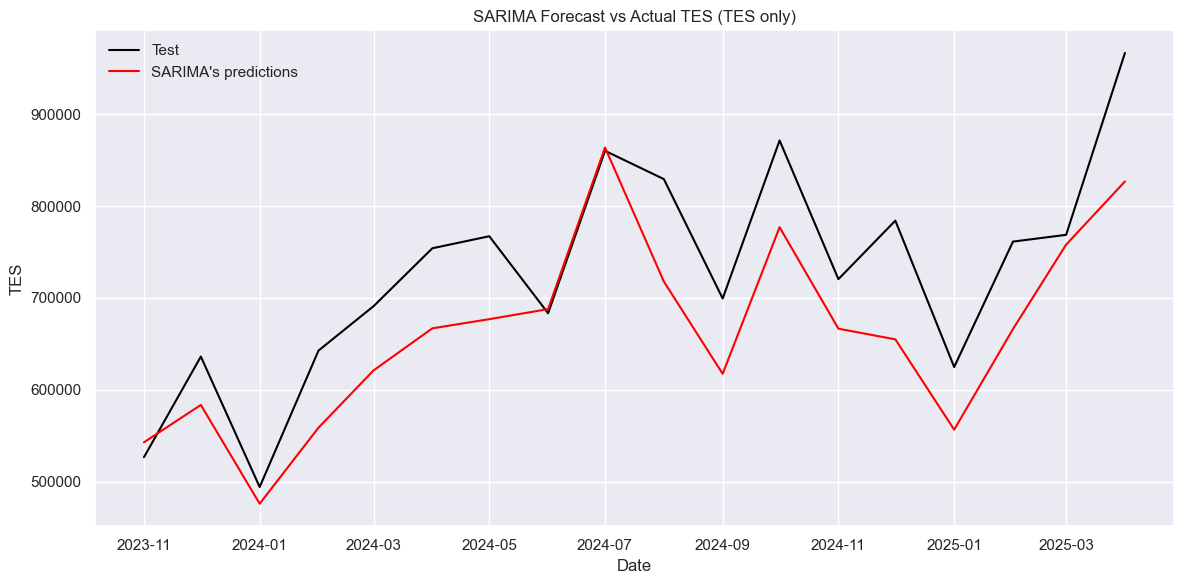

In [168]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_a.index, test_a['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [169]:
# meilleur = grid_search_sarima(train_b)

In [170]:
# model = SARIMAX(train_b["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
# results = model.fit(disp=False)
# predictions = results.predict(start=test_b.index[0], end=test_b.index[-1])

In [171]:
# rmse = root_mean_squared_error(test_b['TES'], predictions)
# r2 = r2_score(test_b['TES'], predictions)
# mae = mean_absolute_error(test_b['TES'], predictions)
# mape = mean_absolute_percentage_error(test_b['TES'], predictions)

# print("="*15,"Metrics Test","="*15)
# print(f"RMSE: {rmse:,.2f}")
# print(f"MAE: {mae:,.2f}")
# print(f"MAPE: {mape:,.2%}")
# print(f"R²: {r2:.2%}")
# print(f"R²: {r2:.4f}")

In [172]:
# #Visualization
# plt.figure(figsize=(12,6))
# plt.plot(test_b.index, test_b['TES'], label='Test', color='black')
# plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
# plt.title("SARIMA Forecast vs Actual TES (TES only)")
# plt.xlabel("Date")
# plt.ylabel("TES")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [177]:
train_end = len(df) - 18


In [178]:
test_row = df.iloc[train_end + 0].copy()
test_row

TES                526626.0
marrakech_lag_1        67.0
TES_diff1         -125167.0
TES_diff2         -276950.0
Name: 2023-11-01 00:00:00, dtype: float64

### Expanding window

In [179]:

# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        y_train =  train[target]
        model = SARIMAX(y_train,order=(0,1,0),seasonal_order=(2,2,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index)[0]
        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)

# UTILISATION
# df = pd.read_csv('ventes.csv')  # Vos données
# df = prep(df, date='date', target='ventes')
# results = forecast(df, test=18)

In [180]:
results1 = forecast(df, test=18)

======================================== le test némero  1 ========================================
======================================== le test némero  2 ========================================
======================================== le test némero  3 ========================================
======================================== le test némero  4 ========================================
======================================== le test némero  5 ========================================
======================================== le test némero  6 ========================================
======================================== le test némero  7 ========================================
======================================== le test némero  8 ========================================
======================================== le test némero  9 ========================================
======================================== le test némero  10 ========================================

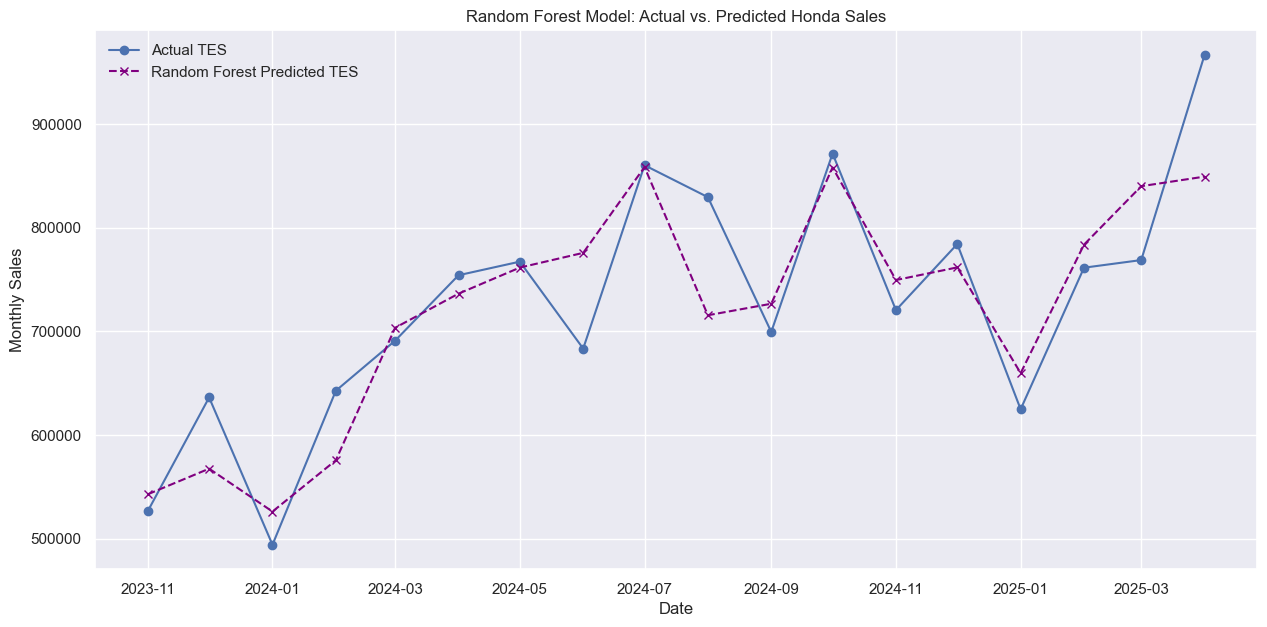

In [181]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results1.index, results1['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results1.index, results1['predicted'].values, label='Random Forest Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()